# Анализ гипотез для увеличения выручки интернет-магазина путем проведения А/B-теста


Проект выполнен для крупного интернет-магазина. Вместе с отделом маркетинга подгтовлен список гипотез для увеличения выручки.


План работы:
- описание данных
- загрузка библиотек
- подготовка данных
- приоретизация гипотез
- проведение A/B-теста
- анализ результатов
- общий вывод

## Описание данных

Файл /datasets/hypothesis.csv. 

    Hypothesis — краткое описание гипотезы;
    Reach — охват пользователей по 10-балльной шкале;
    Impact — влияние на пользователей по 10-балльной шкале;
    Confidence — уверенность в гипотезе по 10-балльной шкале;
    Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл /datasets/orders.csv. 

    transactionId — идентификатор заказа;
    visitorId — идентификатор пользователя, совершившего заказ;
    date — дата, когда был совершён заказ;
    revenue — выручка заказа;
    group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.

    date — дата;
    group — группа A/B-теста;
    visitors — количество пользователей в указанную дату в указанной группе A/B-теста

## Загрузка библиотек

In [1]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

import warnings 
warnings.filterwarnings('ignore')

## Предобработка данных

Прочитаем csv файлы

Выгрузим первые строки датасетов и информацию о них для первичной проверки качества данных.

In [3]:
pd.set_option('max_colwidth', None)
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


In [4]:
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [5]:
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [6]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [8]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Переименуем столбцы hypothesis и orders в соответствии со snake_case, уберем заглавные буквы

In [9]:
hypothesis.columns = [x.lower() for x in hypothesis.columns]
orders.columns = [x.lower() for x in orders.columns]

Изменим тип данных - в датасете orders для столбца date, в датасете visitors для столбца date - c типа object к типу datetime

In [10]:
visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

Проверим наличие явных дубликатов

In [11]:
for table in [visitors, orders]:
    print(table.duplicated().sum())

0
0


Проверим наличие пропусков в данных

In [12]:
for table in [visitors, orders]:
    display(table.isna().sum())

date        0
group       0
visitors    0
dtype: int64

transactionid    0
visitorid        0
date             0
revenue          0
group            0
dtype: int64

Дубликатов и пропусков в не выявлено, данные готовы для анализа.

## Приоретизация гипотез

Приоритизировать гипотезы можно различными способами. Разные фреймворки оценки значимости гипотез содержат несколько отличающиеся параметры, которые учитываются в процессе приоритизации гипотез. В данном проекте будут использованы фреймворки ICE и RICE.

### Применение фреймворка ICE

Фреймворк ICE состоит из трех компонент:

__ICE = Impact (влияние на пользователей) * Confidence (уверенность в гипотезе) * Ease (простота проверки гипотезы)__

или, через затраты,

__ICE = Impact (влияние на пользователей) * Confidence (уверенность в гипотезе) / Efforts (затраты ресурсов на проверку гипотезы)__

Рассчитаем параметр ICE для каждой из представленных гипотез:

In [13]:
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence'] / hypothesis['efforts']).round(2)
hypothesis.sort_values(by='ICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


__Вывод:__
Согласно оценке по методу ICE, первой следует проверить гипотезу с индексом 8, предлагающую запустить акцию с предложением скидки на товар в день рождения(ICE равен 16,20). На втором месте гипотеза 0 о добавлении двух новых каналов привлечения трафика (ICE = 13,33). На третьем месте перспективных гипотез предложение 7 - добавить форму подписки на основные страницы магазина (ICE = 11,20). Все лидеры имеют среднюю оценку по затратам усилий на их проверку (efforts = 5-6), высокие показатели влияния на пользователей (impact = 7-10), а также уверенности в достоверности гипотез (сonfidence = 8-9).

### Применение фреймворка RICE

Фреймворк RICE состоит из четырёх компонент:

__RICE = (Reach (скольких пользователей затронет изменение) * Impact (влияние на пользователей) * Confidence (уверенность в гипотезе)) / Efforts (сколько стоит протестировать гипотезу)__

In [14]:
hypothesis['RICE'] = hypothesis['reach'] * hypothesis['impact']\
    * hypothesis['confidence'] / hypothesis['efforts'].round(2)
hypothesis.sort_values(by='RICE', ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


__Вывод:__
Согласно оценке по методу RICE, первой следует проверить гипотезу с индексом 7, предлагающую добваить форму подписки на все основные страницы для сбора базы данных для рассылок(RICE = 112,0). На втором месте гипотеза 2 о добавлении блоков рекомендаций товаров на сайт интернет-магазина (RICE = 56,0). Третье место делят гипотезы 0 (добавить два новых канала привлечения трафика) и 6 (показать на главной странице баннеры с актуальными распродажами и акциями) с равным значением (RICE = 40,0). Все лидеры имеют оценку по затратам усилий на их проверку от низкой до средней (efforts = 3-6), показатели влияния на пользователей от низкого до макисмального (impact = 3-10), высокую уверенности в достоверности гипотез (сonfidence = 7-8).

### Изменение приоретизации после применения RICE после ICE

Приоритизация предлагаемых гипотез производилась по двум фреймворкам: ICE и RICE. 

Согласно оценке по методу ICE, первой следует проверить гипотезу с индексом 8, предлагающую запустить акцию с предложением скидки на товар в день рождения(ICE равен 16,20). На втором месте гипотеза 0 о добавлении двух новых каналов привлечения трафика (ICE = 13,33). На третьем месте перспективных гипотез предложение 7 - добавить форму подписки на основные страницы магазина (ICE = 11,20).

Согласно оценке по методу RICE, первой следует проверить гипотезу с индексом 7, предлагающую добваить форму подписки на все основные страницы для сбора базы данных для рассылок(RICE = 112,0). На втором месте гипотеза 2 о добавлении блоков рекомендаций товаров на сайт интернет-магазина (RICE = 56,0). Третье место делят гипотезы 0 (добавить два новых канала привлечения трафика) и 6 (показать на главной странице баннеры с актуальными распродажами и акциями) с равным значением (RICE = 40,0).

С учетом охвата доли пользователей изменениями той или иной гипотезы (параметр reach), порядок приоритизации гипотез поменятся. По методу RICE, первой следует проверить гипотезу с индексом 7, предлагающую добваить форму подписки на все основные страницы для сбора базы данных для рассылок(RICE = 112,0). Это изменение каснется всех пользователей (reach = 10). Гипотеза 2 о добавлении блоков рекомендаций товаров на сайт интернет-магазина (RICE = 56,0) затронет существенную часть пользователей (оценка 8 из 10), но затраты на проверку оценены в 3 балла из 10. Третье место делят гипотезы 0 (добавить два новых канала привлечения трафика) и 6 (показать на главной странице баннеры с актуальными распродажами и акциями) с равным значением (RICE = 40,0). Охват аудитории для гипотезы 0 составит 3 из 10, треть всех пользователей. Охват аудитории для гипотезы 6 составит 5 из 10, половину пользователей. Влияние на пользователей оценивается в 10 для гипотезы 0 и в 3 для гипотезы 6. 

Несмотря на отличия, топ-5 гипотез по обоим фреймворкам совпадает:

    7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
    0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей	
    6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	
    8 - Запустить акцию, дающую скидку на товар в день рождения


## Анализ А/B-теста

Проведен A/B-тест, получены результаты, которые описаны в файлах orders.csv и visitors.csv.

Сделаем срезы данных, чтобы отдельно увидеть группы A и B. Соединим полученные данные в единую таблицу.

In [15]:
visitors_A = visitors.loc[visitors['group'] == 'A'].drop('group', axis=1)
visitors_B = visitors.loc[visitors['group'] == 'B'].drop('group', axis=1)
visitors_grouped = visitors_A.merge(visitors_B, on='date', how='outer')
visitors_grouped.columns = ['date', 'visitors_A', 'visitors_B']
visitors_grouped.head(10)

,date,visitors_A,visitors_B
0,2019-08-01,719,713
1,2019-08-02,619,581
2,2019-08-03,507,509
3,2019-08-04,717,770
4,2019-08-05,756,707
5,2019-08-06,667,655
6,2019-08-07,644,709
7,2019-08-08,610,654
8,2019-08-09,617,610
9,2019-08-10,406,369


In [16]:
visitors_grouped.describe()

,visitors_A,visitors_B
count,31.000000,31.000000
mean,604.387097,610.193548
std,112.396227,118.156230
min,361.000000,369.000000
25%,541.000000,537.000000
50%,619.000000,654.000000
75%,705.000000,711.000000
max,756.000000,770.000000


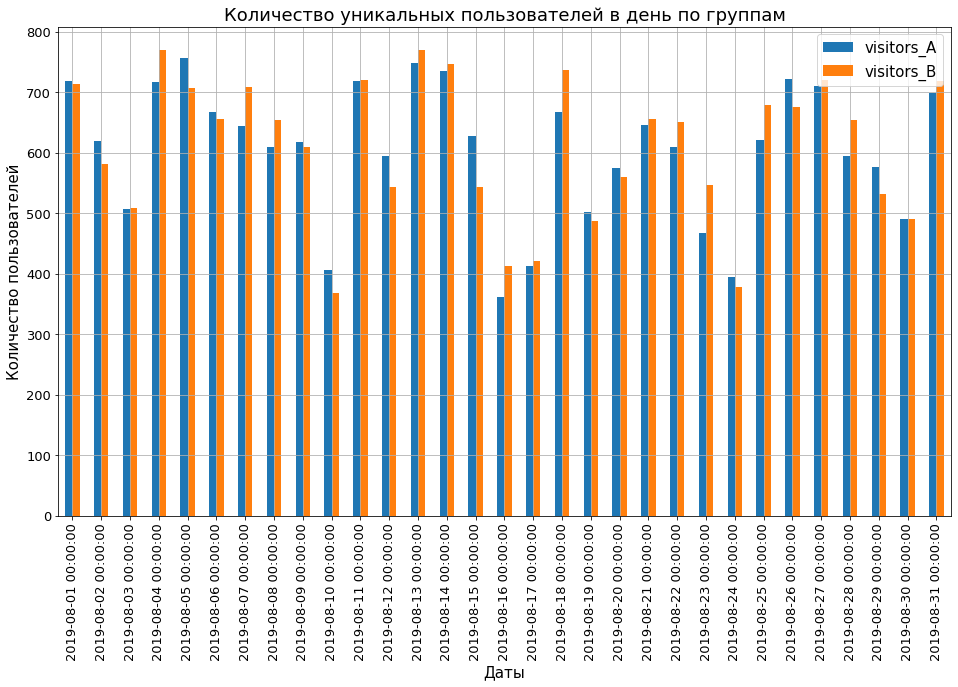

In [17]:
visitors_grouped.plot(x='date', y=['visitors_A', 'visitors_B'], kind='bar', 
                                            figsize=(16,9), grid=True, fontsize=13)

plt.title('Количество уникальных пользователей в день по группам',
          fontsize=18)
plt.ylabel('Количество пользователей', fontsize=15)
plt.xlabel('Даты', fontsize=15)

plt.xticks(rotation=90)
plt.legend(fontsize=15)
plt.show()

Активность пользователей по дням изменялась в обеих группах теста. Общие колебания количества пользователей в разные дни связаны, вероятно, с поведением пользователей в будни и в выходные дни. Среднее число посетителей сайта в каждой группе теста составляет порядка 600 пользователей в день.

### График кумулятивной выручки по группам

Группируем данные по заказам и группам:

In [18]:
date_group = orders[['date','group']].drop_duplicates()

orders_aggregated = date_group.apply(lambda x: 
                                     orders[np.logical_and(orders['date'] <= x['date'], 
                                                           orders['group'] == x['group'])
                                           ].agg({
                                         'date' : 'max', 
                                         'group' : 'max', 
                                         'transactionid' : pd.Series.nunique, 
                                         'visitorid' : pd.Series.nunique, 
                                         'revenue' : 'sum'}), 
                                     axis=1).sort_values(by=['date','group'])

orders_aggregated.columns = ['date', 'group', 'orders', 'buyers', 'revenue']
orders_aggregated

,date,group,orders,buyers,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,21,20,101217
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,45,43,266748
291,2019-08-03,A,68,62,354874
...,...,...,...,...,...
496,2019-08-29,B,596,544,5559398
730,2019-08-30,A,545,493,4022970
690,2019-08-30,B,620,567,5774631
958,2019-08-31,A,557,503,4084803


Делаем срезы данных по группам и строим график.

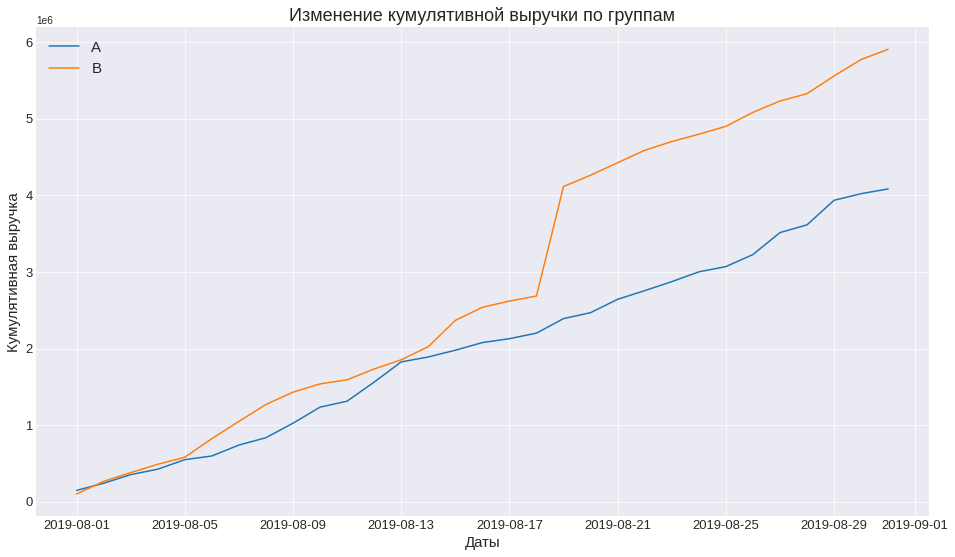

In [19]:
cumulative_revenue_A = orders_aggregated[orders_aggregated['group']=='A'][['date','revenue']]
cumulative_revenue_B = orders_aggregated[orders_aggregated['group']=='B'][['date','revenue']]

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,9))

plt.plot(cumulative_revenue_A['date'], cumulative_revenue_A['revenue'], label='A')
plt.plot(cumulative_revenue_B['date'], cumulative_revenue_B['revenue'], label='B')

plt.title('Изменение кумулятивной выручки по группам', fontsize=18)

plt.ylabel('Кумулятивная выручка', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.show()

В начале теста различие в выручке между группами было невелико, но после 18 августа группа B показывает резкий рост кумулятивной выручки. Вероятно наличие выбросов в данных.

### График кумулятивного среднего чека по группам

Группируем аналогичным образом данные по визитам и группам.

In [20]:
visitors_aggregated = date_group.apply(lambda x: 
                                       visitors[np.logical_and(
                                           visitors['date'] <= x['date'], 
                                           visitors['group'] == x['group'])
                                               ].agg({
                                           'date' : 'max', 
                                           'group' : 'max', 
                                           'visitors' : 'sum'}), 
                                       axis=1).sort_values(by=['date','group'])

visitors_aggregated

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845
...,...,...,...
496,2019-08-29,B,17708
730,2019-08-30,A,18037
690,2019-08-30,B,18198
958,2019-08-31,A,18736


Собираем агрегированные данные в один датасет.

In [21]:
cumulative_data = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], 
                                        right_on=['date', 'group'])

Рассчитаем средний чек

In [22]:
cumulative_data['revenue_per_order'] = cumulative_data['revenue'] / cumulative_data['orders']
cumulative_data

,date,group,orders,buyers,revenue,visitors,revenue_per_order
0,2019-08-01,A,24,20,148579,719,6190.791667
1,2019-08-01,B,21,20,101217,713,4819.857143
2,2019-08-02,A,44,38,242401,1338,5509.113636
3,2019-08-02,B,45,43,266748,1294,5927.733333
4,2019-08-03,A,68,62,354874,1845,5218.735294
...,...,...,...,...,...,...,...
57,2019-08-29,B,596,544,5559398,17708,9327.848993
58,2019-08-30,A,545,493,4022970,18037,7381.596330
59,2019-08-30,B,620,567,5774631,18198,9313.920968
60,2019-08-31,A,557,503,4084803,18736,7333.578097


Делаем срез данных по группам и строим график.

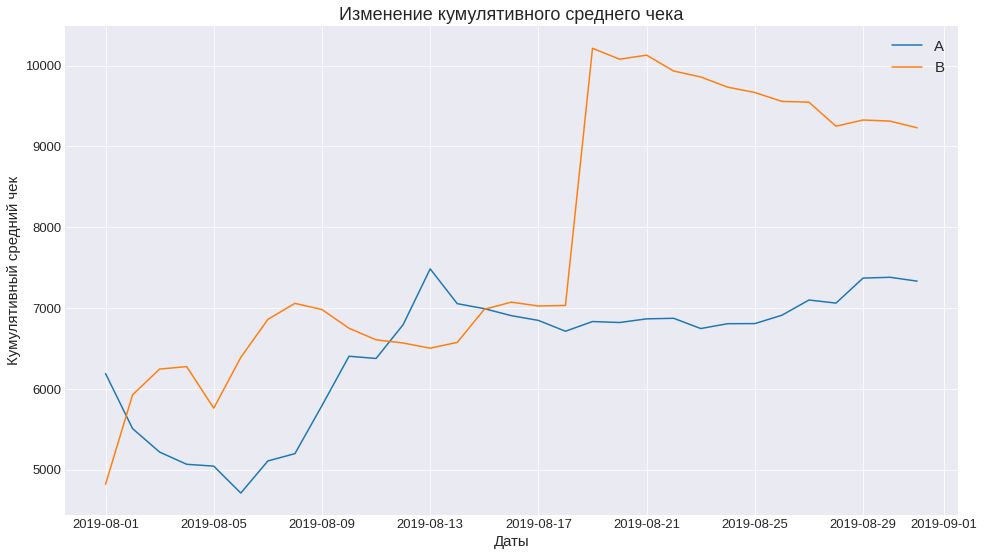

In [23]:
cumulative_data_A = cumulative_data[cumulative_data['group']=='A'][['date', 'revenue_per_order']]
cumulative_data_B = cumulative_data[cumulative_data['group']=='B'][['date', 'revenue_per_order']]

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,9))

plt.plot(cumulative_data_A['date'], cumulative_data_A['revenue_per_order'], label='A')
plt.plot(cumulative_data_B['date'], cumulative_data_B['revenue_per_order'], label='B')

plt.title('Изменение кумулятивного среднего чека', fontsize=18)
plt.ylabel('Кумулятивный средний чек', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.legend(fontsize=15)
plt.show()

Для кумулятивного среднего чека мы так же наблюдаем резкий скачок показателя для группы В после 18 августа. Вероятно наличие выбросов в данных, скорее всего, в период 18-19 августа встречаются дорогие заказы.

### График относительного изменения кумулятивного среднего чека группы B к группе A

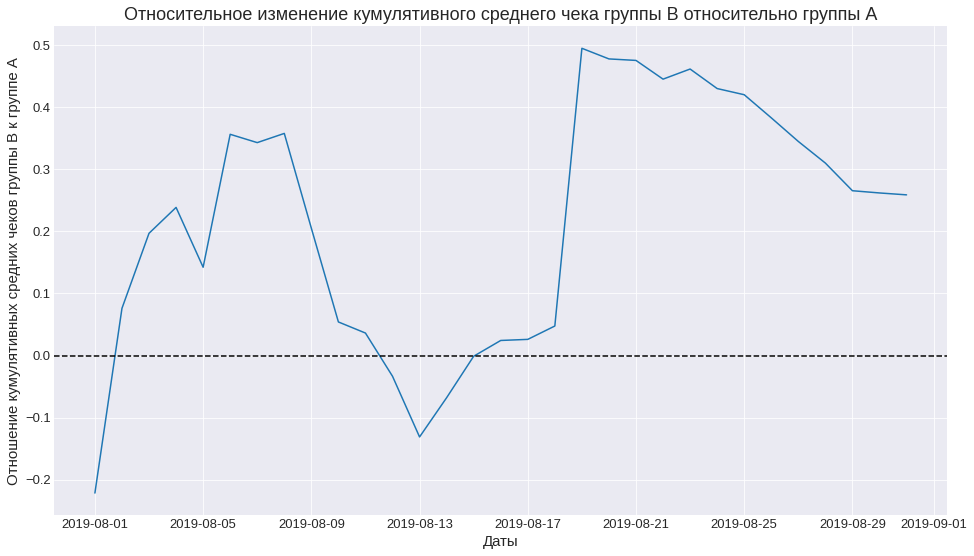

In [24]:
merged_сumulative_data = cumulative_data_A.merge(
    cumulative_data_B, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16,9))

plt.plot(merged_сumulative_data['date'], 
         merged_сumulative_data['revenue_per_orderB'] / merged_сumulative_data['revenue_per_orderA'] - 1)

plt.axhline(y=0, color='black', linestyle='--') 

plt.title('Относительное изменение кумулятивного среднего чека группы В относительно группы А',
          fontsize=18)
plt.ylabel('Отношение кумулятивных средних чеков группы В к группе А', fontsize=15)
plt.xlabel('Даты', fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

Резкие скачки кумулятивного среднего чека группы В относительно группы А в нескольких местах графика также указывают на наличие в данных некоторого объема дорогих заказов. Все три графика, касающиеся кумулятивной выручки, демонстрируют схожую картину.

### График кумулятивного среднего количества заказов на посетителя по группам

Сгруппируем данные по визитам и платежам за заказы, чтобы определить количество заказов на каждого пользователя.

In [25]:
cumulative_data_plus = orders_aggregated.merge(visitors_aggregated, left_on=['date', 'group'], 
                                        right_on=['date', 'group'])
cumulative_data_plus ['conversion'] = cumulative_data_plus['orders']/cumulative_data_plus['visitors']

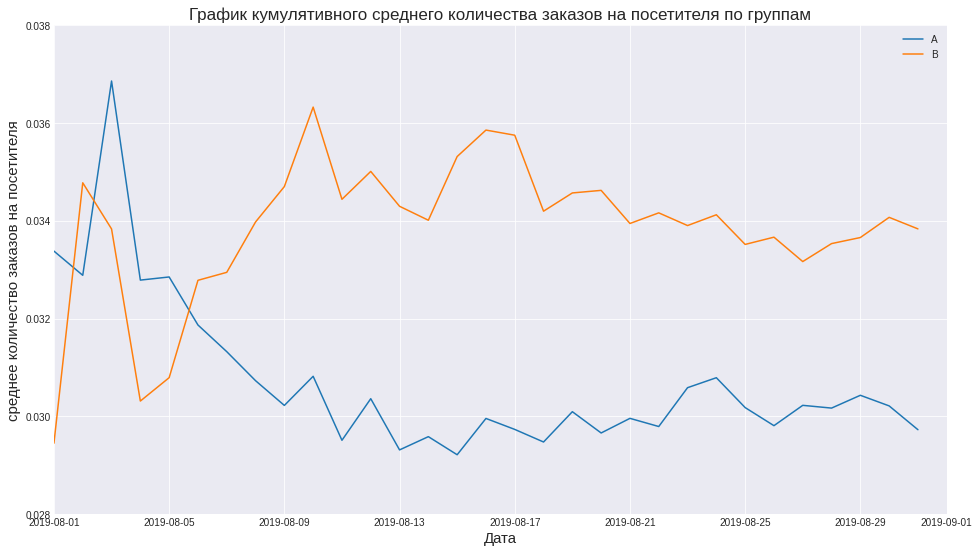

In [26]:
cumulative_data_A_plus = cumulative_data_plus[cumulative_data_plus['group']=='A'][['date', 'conversion']]
cumulative_data_B_plus = cumulative_data_plus[cumulative_data_plus['group']=='B'][['date', 'conversion']]

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16, 9))
plt.plot(cumulative_data_A_plus['date'], cumulative_data_A_plus['conversion'], label='A')
plt.plot(cumulative_data_B_plus['date'], cumulative_data_B_plus['conversion'], label='B')

plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 9, 1), 0.028, 0.038])
plt.title('График кумулятивного среднего количества заказов на посетителя по группам', fontsize=17)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('среднее количество заказов на посетителя', fontsize=15)
plt.legend()
plt.show()

В начале теста среднее число заказов группы А была была выше, однако среднее число заказов группы B после 5 августа превзошло показатель группы А. В дальнейшем периоде наблюдений среднее число заказов группы В стабильно выше аналогичного показателя группы А.

### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

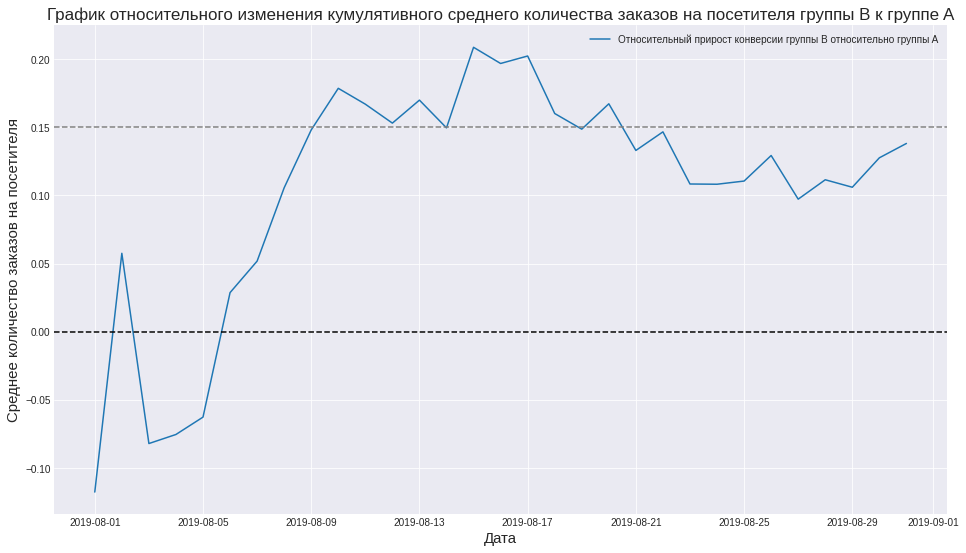

In [27]:
merged_сumulative_сonversions = cumulative_data_A_plus[['date','conversion']].merge(cumulative_data_B_plus[['date','conversion']], 
                                  left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(16, 9))
plt.plot(merged_сumulative_сonversions['date'], merged_сumulative_сonversions['conversionB']/
         merged_сumulative_сonversions['conversionA']-1, 
         label="Относительный прирост конверсии группы B относительно группы A")


plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.15, color='grey', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A',fontsize=17)
plt.xlabel('Дата', fontsize=15)
plt.ylabel('Среднее количество заказов на посетителя', fontsize=15)
plt.legend()
plt.show()

Группа B выходит вперед относительно показателей группы А после 5-го дня теста, далее лидирует с преимуществом около 15% до конца проведения теста.

### Точечный график количества заказов по пользователям

Сгруппируем данные по числу закзов на пользователя.

In [28]:
orders_per_user = orders.groupby('visitorid', as_index=False).agg({'transactionid':'nunique'})\
                         .rename(columns={'transactionid':'orders'})

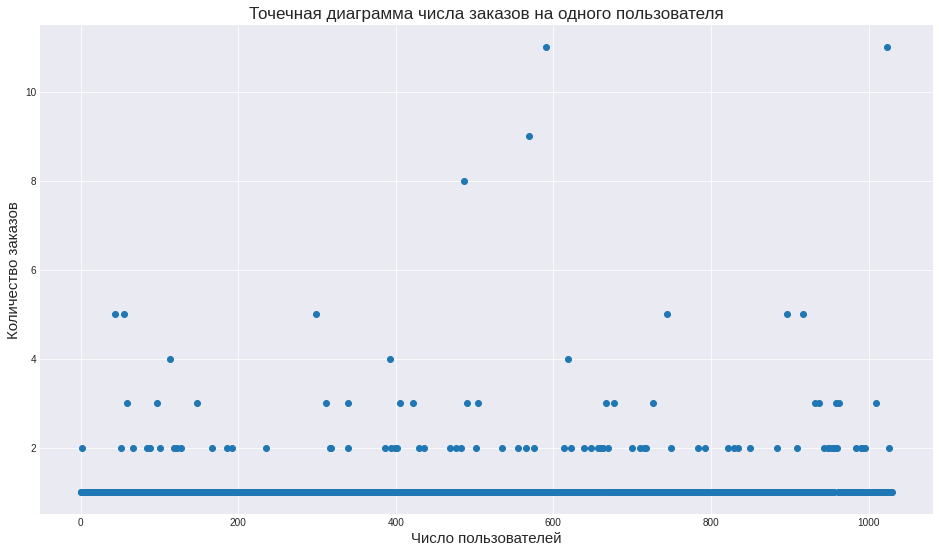

In [29]:
x_values = pd.Series(range(0, len(orders_per_user)))

plt.figure(figsize=(16,9))
plt.scatter(x_values, orders_per_user['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя', fontsize=17)
plt.xlabel('Число пользователей', fontsize=15)
plt.ylabel('Количество заказов', fontsize=15)
plt.show()

Преимущественно заказывают 1 раз. Присутствуют аномальные значения - более 10 заказов

### 95-й и 99-й перцентили количества заказов на пользователя

In [30]:
print('95 перцентиль: %.2f' % (np.percentile(orders_per_user['orders'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders_per_user['orders'], [99])))

95 перцентиль: 2.00
99 перцентиль: 4.00


Менее 5% пользователей оформляли больше 2х заказов, 1% пользователей заказывали больше 4 раз. Примем за границу выбросов 99-й перцентиль, 4 заказа и более.

### Точечный график стоимостей заказов

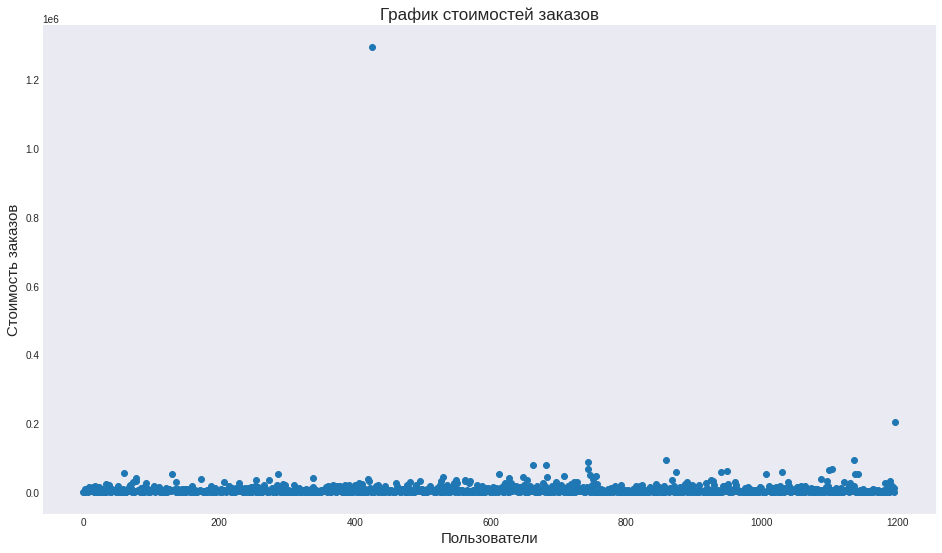

In [31]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(16, 9))
plt.scatter(x_values, orders['revenue']) 

plt.title("График стоимостей заказов", fontsize=17)
plt.xlabel('Пользователи', fontsize=15)
plt.ylabel('Стоимость заказов', fontsize=15)
plt.grid()
plt.show()

Ограничим значения по оси Y, чтобы оценить картину распределения без двух выборосов.

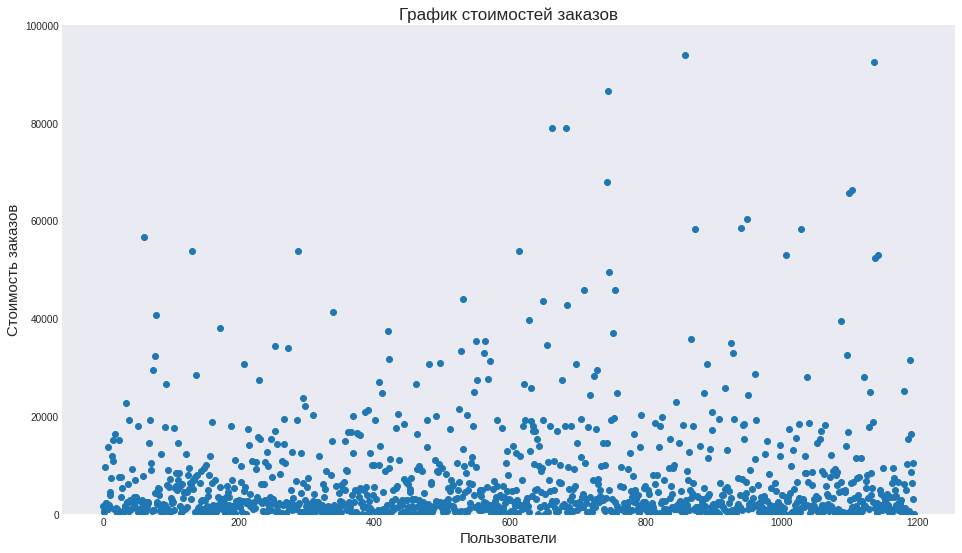

In [32]:
x_values = pd.Series(range(0, len(orders['revenue'])))

plt.figure(figsize=(16, 9))
plt.scatter(x_values, orders['revenue']) 

plt.ylim(0,100000)
plt.title("График стоимостей заказов", fontsize=17)
plt.xlabel('Пользователи', fontsize=15)
plt.ylabel('Стоимость заказов', fontsize=15)
plt.grid()
plt.show()

На графике видны выбивающиеся одиночные точки со ориентировочным значением 1,3 млн и 200 тысяч. Остальные данные распределены значительно ниже этих уровней, преимущественно до 30000. 

### 95-й и 99-й перцентили стоимости заказов

In [33]:
print('95 перцентиль: %.2f' % (np.percentile(orders['revenue'], [95])))
print('99 перцентиль: %.2f' % (np.percentile(orders['revenue'], [99])))

95 перцентиль: 28000.00
99 перцентиль: 58233.20


Менее 5% пользователей потратили на заказы более 28 тысяч, 1% пользователей потратили более 58,2 тысяч. Примем за границу выбросов 95-й перцентиль, тех, кто потратил более 28 тысяч.

### Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным

Создадим переменные orders_by_users_A и orders_by_users_B со столбцами ['userid', 'orders'], где для пользователей, совершивших хотя бы 1 заказ, будет указано число заказов. Объявим переменные sampleA и sampleB, в которых пользователям с заказами будет соответствовать число заказов пользователя. А пользователям без заказов — нули. 

Значение alpha примем равным 0.05

Это нужно для подготовить выборок к проверке критерием Манна-Уитни:

    H0:Среднее количество заказов на посетителя групп A и B равны, статистически значимых отличий нет;
    H1:Среднем количество заказов на посетителя групп A и B различны, статистически значимые отличия есть.

In [34]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}), axis=1,)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}),axis=1,)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False).agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}),axis=1,).sort_values(by=['date'])
ordersACummulative.columns = ['date','ordersCummulativeA','revenueCummulativeA',]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionid', 'visitorid', 'revenue']]
    .groupby('date', as_index=False).agg({'transactionid': pd.Series.nunique, 'revenue': 'sum'}))
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}),axis=1,).sort_values(by=['date'])
ordersBCummulative.columns = ['date','ordersCummulativeB','revenueCummulativeB',]

In [35]:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [36]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersA.columns = ['visitorid', 'transactionid']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorid', as_index=False)
    .agg({'transactionid': pd.Series.nunique}))
ordersByUsersB.columns = ['visitorid', 'transactionid'] 

sampleA = pd.concat([ordersByUsersA['transactionid'],pd.Series(0, 
          index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionid'])), name='orders')],axis=0)

sampleB = pd.concat([ordersByUsersB['transactionid'],pd.Series(0, 
          index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionid'])), name='orders')],axis=0)

print('p-value:',"{0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print('Относительные различия:',"{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value: 0.017
Относительные различия: 0.138


P-value значительно меньше 0.05, значит стоит отвергнуть нулевую гипотезу. "Сырые данные" говорят, что в среднем количестве заказов между группами есть статистически значимые различия. 

### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Проверяем следующие гипотезы по критерию Манна-Уитни:

    H0:Средние чеки групп A и B равны, статистически значимых отличий нет;
    H1:Средние чеки групп A и B различны, статистически значимые отличия есть.

In [37]:
print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], 
                                                     orders[orders['group']=='B']['revenue'])[1]))
print('Относительные различия:','{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/
                                                 orders[orders['group']=='A']['revenue'].mean() - 1))

p-value: 0.729
Относительные различия: 0.259


P-value значительно больше 0.05, статистически значимых отличий в среднем чеке между группами нет. Кроме того, относительное различие среднего чека между группами составляет 25.9%. Отвергнуть нулевую гипотезу нельзя.

### Cтатистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным

Для получение наиболее объективных данных необходимо провести очистку датасетов от аномалий. 

95-й и 99-й перцентили средних чеков равны 28 тыс и 58,233 тыс.
95-й и 99-й перцентили числа заказов на одного пользователя равны 2 и 4 заказам на пользователя.

Примем за аномальных пользователей тех, кто потратил более 28 тыс, либо совершил 4 и более заказов.

Значение alpha примем равным 0.05

Проверка критерием Манна-Уитни:

    H0:Среднее количество заказов на посетителя групп A и B равны, статистически значимых отличий нет;
    H1:Среднем количество заказов на посетителя групп A и B различны, статистически значимые отличия есть.

In [38]:
usersWithManyOrders = pd.concat(
    [ordersByUsersA[ordersByUsersA['transactionid'] > (np.percentile(orders_per_user['orders'], 99))]['visitorid'],
     ordersByUsersB[ordersByUsersB['transactionid'] > (np.percentile(orders_per_user['orders'], 99))]['visitorid'],
    ],axis=0,)
usersWithExpensiveOrders = orders[orders['revenue'] > (np.percentile(orders['revenue'], 95))]['visitorid']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0).drop_duplicates().sort_values())


Создадим переменные sampleA_filtered и sampleB_filtered, в которых сохраним очищенные данные о заказах. Выведем p-value для сравнения среднего между очищенными группами данных. 

In [39]:
sampleA_filtered = pd.concat(
    [ ordersByUsersA[
     np.logical_not(ordersByUsersA['visitorid'].isin(abnormalUsers))]['transactionid'],
        pd.Series(0,
            index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['transactionid'])),
            name='orders',),
    ], axis=0,)

sampleB_filtered = pd.concat(
    [ordersByUsersB[
     np.logical_not(ordersByUsersB['visitorid'].isin(abnormalUsers))]['transactionid'],
        pd.Series(0,index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['transactionid'])
            ),name='orders',),
    ],axis=0,) 

print('p-value:','{0:.3f}'.format(stats.mannwhitneyu(sampleA_filtered, sampleB_filtered)[1]))
print('Относительные различия:','{0:.3f}'.format(sampleB_filtered.mean()/sampleA_filtered.mean()-1)) 

p-value: 0.018
Относительные различия: 0.145


P-value значительно меньше 0.05, как и в случае с сырым данными, статистическая значимость достигнута. Можно отвергнуть нулевую гипотезу.

### Cтатистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Значение alpha примем равным 0.05

Проверяем следующие гипотезы по критерию Манна-Уитни:

    H0:Средние чеки групп A и B равны, статистически значимых отличий нет;
    H1:Средние чеки групп A и B различны, статистически значимые отличия есть.

In [40]:
print('p-value:',
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),)
            ]['revenue'],
            orders[np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorid'].isin(abnormalUsers)),)
            ]['revenue'],
        )[1]
    )
)

print('Относительные различия:',
    "{0:.3f}".format(
        orders[np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),)
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorid'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value: 0.961
Относительные различия: -0.014


Значение p-value стало больше с 0.729 до 0.961, однако относительные различия уменьшились с 25.9% до 1,4%, что означает, что в данных стало меньше "шума" и искажений. Значение p-value значительно превышает 0,05, отвергнуть нулевую гипотезу нельзя. 

## Общий вывод:

Проект выполнен для крупного интернет-магазина. Вместе с отделом маркетинга подгтовлен список гипотез для увеличения выручки.
Проведена предобработка данных, проверка на пропущенные значения и дубликаты.

Приоритизация предлагаемых гипотез производилась по двум фреймворкам: ICE и RICE.

Согласно оценке по методу ICE, первой следует проверить гипотезу с индексом 8, предлагающую запустить акцию с предложением скидки на товар в день рождения(ICE равен 16,20). На втором месте гипотеза 0 о добавлении двух новых каналов привлечения трафика (ICE = 13,33). На третьем месте перспективных гипотез предложение 7 - добавить форму подписки на основные страницы магазина (ICE = 11,20).

Согласно оценке по методу RICE, первой следует проверить гипотезу с индексом 7, предлагающую добваить форму подписки на все основные страницы для сбора базы данных для рассылок(RICE = 112,0). На втором месте гипотеза 2 о добавлении блоков рекомендаций товаров на сайт интернет-магазина (RICE = 56,0). Третье место делят гипотезы 0 (добавить два новых канала привлечения трафика) и 6 (показать на главной странице баннеры с актуальными распродажами и акциями) с равным значением (RICE = 40,0).

С учетом охвата доли пользователей изменениями той или иной гипотезы (параметр reach), порядок приоритизации гипотез поменятся. По методу RICE, первой следует проверить гипотезу с индексом 7, предлагающую добваить форму подписки на все основные страницы для сбора базы данных для рассылок(RICE = 112,0). Это изменение каснется всех пользователей (reach = 10). Гипотеза 2 о добавлении блоков рекомендаций товаров на сайт интернет-магазина (RICE = 56,0) затронет существенную часть пользователей (оценка 8 из 10), но затраты на проверку оценены в 3 балла из 10. Третье место делят гипотезы 0 (добавить два новых канала привлечения трафика) и 6 (показать на главной странице баннеры с актуальными распродажами и акциями) с равным значением (RICE = 40,0). Охват аудитории для гипотезы 0 составит 3 из 10, треть всех пользователей. Охват аудитории для гипотезы 6 составит 5 из 10, половину пользователей. Влияние на пользователей оценивается в 10 для гипотезы 0 и в 3 для гипотезы 6.

Несмотря на отличия, топ-5 гипотез по обоим фреймворкам совпадает:

    7 - Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
    2 - Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
    0 - Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей    
    6 - Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию    
    8 - Запустить акцию, дающую скидку на товар в день рождения


В начале теста различие в кумулятивной выручке между группами было невелико, но после 18 августа группа B показывает резкий рост кумулятивной выручки. Ту же картину наблюдаем по графикам среднего чека. Группа B выходит вперед относительно показателей группы А после 5-го дня теста, далее лидирует с преимуществом около 15% до конца проведения теста.

Преимущественно заказывают 1 раз. Менее 5% пользователей оформляли больше 2х заказов, 1% пользователей заказывали больше 4 раз. 

Менее 5% пользователей потратили на заказы более 28 тысяч, 1% пользователей потратили более 58,2 тысяч.

По полученным значениям процентилей выбраны границы для исключения аномалий.

Выборки проверены по критерию Манна_Уитни, с результате чего получены следующие факты:

    Есть статистически значимое различие в среднем количестве заказов между группами по «очищенным» данным и по "сырым данным".
    Нет статистически значимого различия в среднем чеке заказа между группами ни по «сырым» данным, ни по "очищенным".

График различия среднего количества заказов на посетителя между группами сообщает, что результаты группы B лучше группы A на примерно 15%.
График различия среднего чека говорит о том, что результаты группы B лучше группы А примерно на 20%.

На основании вышесказанного можно принять следующее решение: остановить тест, так как группа B превосходит группу А, фиксируем победу группы В.